In [1]:
# 1. Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    mean_squared_error,
    r2_score,
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


In [2]:
# 2. Datensatz laden & Überblick

def load_heart_dataset(path: str = "heart.csv") -> pd.DataFrame:
    """
    Lädt den Herzkrankheits-Datensatz und gibt ein DataFrame zurück.

    Schritte:
    1. CSV-Datei von dem angegebenen Pfad einlesen.
    2. Form (Anzahl Samples und Features) und Spaltennamen ausgeben.
    3. Fehlende Werte pro Spalte anzeigen, um Datenqualität zu prüfen.
    4. Die ersten Zeilen des DataFrames anzeigen, um einen Eindruck zu bekommen.
    """
    df = pd.read_csv(path)

    print("Form des Datensatzes:", df.shape)
    print("Spalten:", list(df.columns))
    print("\nFehlende Werte pro Spalte:\n", df.isna().sum())

    display(df.head())
    return df


df = load_heart_dataset("heart.csv")


Form des Datensatzes: (918, 12)
Spalten: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

Fehlende Werte pro Spalte:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0



Numerische Features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Kategoriale Features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

=== Random Forest Klassifikation (5-fache Cross-Validation) ===
Accuracy: 0.871

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85       410
           1       0.87      0.91      0.89       508

    accuracy                           0.87       918
   macro avg       0.87      0.87      0.87       918
weighted avg       0.87      0.87      0.87       918

Confusion Matrix:
 [[338  72]
 [ 46 462]]


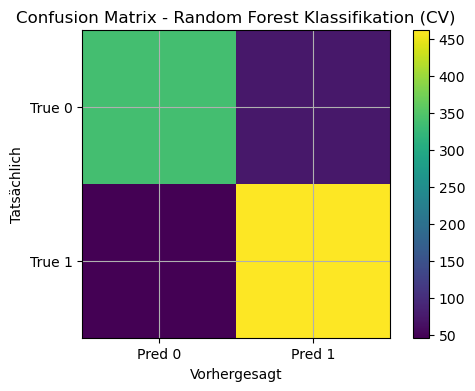

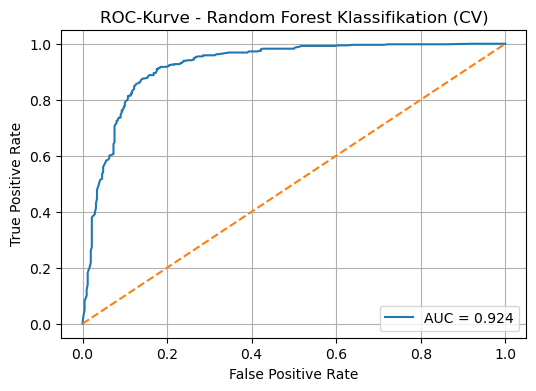

In [5]:
# 3. Random Forest Klassifikation (HeartDisease)

def prepare_classification_data(df: pd.DataFrame):
    """
    Bereitet den Datensatz für die Klassifikation vor.

    Schritte:
    1. Trenne Features (X) und Zielvariable (y), hier: 'HeartDisease'.
    2. Bestimme numerische und kategoriale Spalten.
    3. Gib X, y sowie die Feature-Listen zurück, damit sie im Preprocessing
       und für die Interpretation (Feature Importances) verwendet werden können.
    """
    X_clf = df.drop(columns=["HeartDisease"])
    y_clf = df["HeartDisease"]

    numeric_features_clf = X_clf.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features_clf = [c for c in X_clf.columns if c not in numeric_features_clf]

    print("\nNumerische Features:", numeric_features_clf)
    print("Kategoriale Features:", categorical_features_clf)

    return X_clf, y_clf, numeric_features_clf, categorical_features_clf


def build_classification_pipeline(numeric_features_clf, categorical_features_clf):
    """
    Erstellt die Pipeline für die Random-Forest-Klassifikation.

    Schritte:
    1. Definiere einen ColumnTransformer:
       - StandardScaler für numerische Features.
       - OneHotEncoder für kategoriale Features.
    2. Erzeuge einen RandomForestClassifier mit fester random_state
       für Reproduzierbarkeit.
    3. Fasse Preprocessing und Modell in einer Pipeline zusammen, damit alle
       Schritte in Cross-Validation und späterer Auswertung identisch sind.
    """
    preprocess_clf = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features_clf),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_clf),
        ]
    )

    rf_clf = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )

    clf_pipeline = Pipeline([
        ("preprocess", preprocess_clf),
        ("model", rf_clf)
    ])

    return clf_pipeline


def evaluate_classification_with_cv(
    clf_pipeline,
    X_clf,
    y_clf,
    numeric_features_clf,
    categorical_features_clf,
    cv_splits: int = 5,
):
    """
    Bewertet die Random-Forest-Klassifikation mit k-facher Cross-Validation.

    Schritte:
    1. Erzeuge ein StratifiedKFold-Objekt, damit die Klassenverhältnisse in
       allen Folds ähnlich sind.
    2. Nutze cross_val_predict, um out-of-fold Vorhersagen (Klassenlabels
       und Wahrscheinlichkeiten) zu erzeugen.
    3. Berechne Accuracy, Classification Report, Confusion Matrix, ROC-Kurve
       und AUC anhand der out-of-fold Vorhersagen.
"""
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    # Out-of-fold Vorhersagen (Labels)
    y_pred_clf = cross_val_predict(clf_pipeline, X_clf, y_clf, cv=cv)

    # Out-of-fold Wahrscheinlichkeiten für die positive Klasse
    y_proba_clf = cross_val_predict(
        clf_pipeline,
        X_clf,
        y_clf,
        cv=cv,
        method="predict_proba"
    )[:, 1]

    print(f"\n=== Random Forest Klassifikation ({cv_splits}-fache Cross-Validation) ===")
    print("Accuracy:", round(accuracy_score(y_clf, y_pred_clf), 3))
    print("\nClassification Report:\n", classification_report(y_clf, y_pred_clf))

    # Confusion Matrix
    cm = confusion_matrix(y_clf, y_pred_clf)
    print("Confusion Matrix:\n", cm)

    plt.imshow(cm)
    plt.colorbar()
    plt.xticks([0, 1], ["Pred 0", "Pred 1"])
    plt.yticks([0, 1], ["True 0", "True 1"])
    plt.title("Confusion Matrix - Random Forest Klassifikation (CV)")
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Tatsächlich")
    plt.show()

    # ROC & AUC
    fpr, tpr, _ = roc_curve(y_clf, y_proba_clf)
    auc = roc_auc_score(y_clf, y_proba_clf)

    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-Kurve - Random Forest Klassifikation (CV)")
    plt.legend()
    plt.show()




# --- Ausführung Klassifikation ---
X_clf, y_clf, numeric_features_clf, categorical_features_clf = prepare_classification_data(df)
clf_pipeline = build_classification_pipeline(numeric_features_clf, categorical_features_clf)
evaluate_classification_with_cv(
    clf_pipeline,
    X_clf,
    y_clf,
    numeric_features_clf,
    categorical_features_clf,
    cv_splits=5,
)



=== Random Forest Regression (MaxHR, 5-fache Cross-Validation) ===
MSE: 444.7070308142701
RMSE: 21.088
R²: 0.313


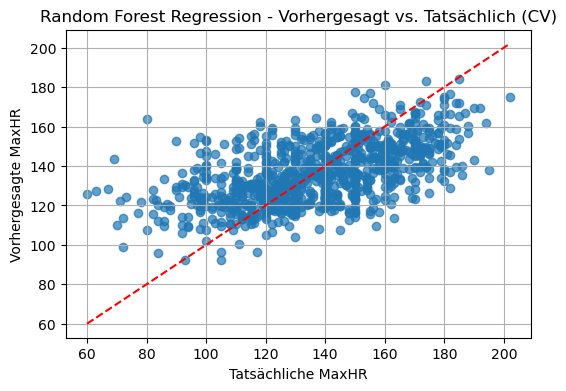

In [7]:
# 4. Random Forest Regression (MaxHR)

def prepare_regression_data(df: pd.DataFrame):
    """
    Bereitet den Datensatz für die Regression auf 'MaxHR' vor.

    Schritte:
    1. Definiere 'MaxHR' als Zielvariable y.
    2. Nutze alle übrigen Spalten als Features X.
    3. Bestimme numerische und kategoriale Features für das Preprocessing.
    """
    X_reg = df.drop(columns=["MaxHR"])
    y_reg = df["MaxHR"]

    numeric_features_reg = X_reg.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features_reg = [c for c in X_reg.columns if c not in numeric_features_reg]

    return X_reg, y_reg, numeric_features_reg, categorical_features_reg


def build_regression_pipeline(numeric_features_reg, categorical_features_reg):
    """
    Erstellt die Pipeline für die Random-Forest-Regression auf 'MaxHR'.

    Schritte:
    1. ColumnTransformer mit:
       - StandardScaler für numerische Features.
       - OneHotEncoder für kategoriale Features.
    2. RandomForestRegressor mit fester random_state für Reproduzierbarkeit.
    3. Pipeline, die zuerst vorverarbeitet und dann den Random Forest trainiert.
    """
    preprocess_reg = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features_reg),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_reg),
        ]
    )

    rf_reg = RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    )

    reg_pipeline = Pipeline([
        ("preprocess", preprocess_reg),
        ("model", rf_reg)
    ])

    return reg_pipeline


def evaluate_regression_with_cv(
    reg_pipeline,
    X_reg,
    y_reg,
    numeric_features_reg,
    categorical_features_reg,
    cv_splits: int = 5,
):
    """
    Bewertet die Random-Forest-Regression mit k-facher Cross-Validation.

    Schritte:
    1. Erzeuge ein KFold-Objekt mit Shuffle, um die Daten in k Splits aufzuteilen.
    2. Nutze cross_val_predict, um out-of-fold Vorhersagen für y zu erhalten.
    3. Berechne MSE, RMSE und R² basierend auf diesen Vorhersagen.
    4. Zeichne einen Scatterplot von tatsächlichen gegen vorhergesagte Werte,
       um die Güte der Regression visuell zu beurteilen.
 """
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    # Out-of-fold Vorhersagen
    y_pred_reg = cross_val_predict(reg_pipeline, X_reg, y_reg, cv=cv)

    mse = mean_squared_error(y_reg, y_pred_reg)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_reg, y_pred_reg)

    print(f"\n=== Random Forest Regression (MaxHR, {cv_splits}-fache Cross-Validation) ===")
    print("MSE:", mse)
    print("RMSE:", round(rmse, 3))
    print("R²:", round(r2, 3))

    # Scatterplot
    plt.scatter(y_reg, y_pred_reg, alpha=0.7)
    plt.plot(
        [y_reg.min(), y_reg.max()],
        [y_reg.min(), y_reg.max()],
        "r--"
    )
    plt.xlabel("Tatsächliche MaxHR")
    plt.ylabel("Vorhergesagte MaxHR")
    plt.title("Random Forest Regression - Vorhergesagt vs. Tatsächlich (CV)")
    plt.show()


# --- Ausführung Regression ---
X_reg, y_reg, numeric_features_reg, categorical_features_reg = prepare_regression_data(df)
reg_pipeline = build_regression_pipeline(numeric_features_reg, categorical_features_reg)
evaluate_regression_with_cv(
    reg_pipeline,
    X_reg,
    y_reg,
    numeric_features_reg,
    categorical_features_reg,
    cv_splits=5,
)
